In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [197]:
np.random.seed(42)

# Monte Carlo Recepices for Simple Statistics

Heavily based on Jake Vanderplas's talk **Statistics for Hackers**

- https://speakerdeck.com/jakevdp/statistics-for-hackers

Other great resources:

- Jake Vanderplas book: Python Data Science Handbook
- Jake Vanderplas blog (Pythonic Perambulations): https://jakevdp.github.io 
- Cam Davidson-Pilon book: https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers

Main goals:

- to show that even complicated-looking statistics can be simple
- to apply Monte Carlo approach (a for loop, Python)

### The Art of Asking the Right Question

## Coin example

Toss 30 times and get 22 heads. Is the coin fair?

- a fair coin should show about 15 heads!
- even a fair coin could show 22, just by chance, it's random

Classiacl method is to test the Null hypothesis

What is the probability of a fair coin showing 22 heads in 30 tosses by chance?

$P(H) = 1/2$

$P(HH) = (1/2)^2$

$P(2H, 1T) = P(HHT) + P(HTH) + P(THH)$

...

Mr Bernoulli:

$P(N_H, N) = \binom{N}{N_H} p^{N_H} (1 - p)^{N - N_H}$

- number of arrangements
- $p$ probability of head
- probability of $N_H$ heads in $N$ tosses

In [227]:
import scipy.stats

In [228]:
[ n, p ] = [ 30, 0.5 ]
rv = scipy.stats.binom(n, p)
n_h = 22
print rv.pmf(n_h)

0.00545096118003


### The concept of p-value

Probability of obtaining a result equal or more exteme than that what was observed, if the null hypothesis is true.

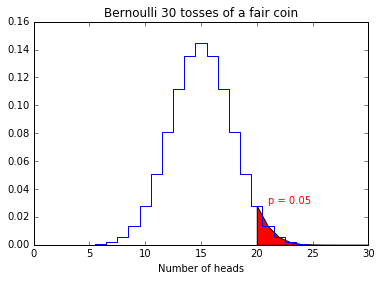

In [229]:
x = np.arange(1, n+1)
v_crit = rv.isf(0.05)

plt.plot(x, rv.pmf(x), linestyle='steps-mid')
plt.fill_between(x[x>v_crit], rv.pmf(x)[x>v_crit], facecolor='red')

#h = plt.vlines(x, 0, rv.pmf(x), lw=2)
#plt.vlines(x[n_h-1:], 0, rv.pmf(x[n_h-1:]), color='red', lw=2)

plt.annotate('p = 0.05',xy=(v_crit+2,0.03),color='red')
plt.title('Bernoulli 30 tosses of a fair coin')
plt.xlabel('Number of heads');

In [230]:
pvalue = scipy.stats.binom_test((22,8), p=p) /2.
# division by 2 because the default is two sided, not one sided
# you can ommit /2 if  alternative='greater' is added
# distribution is symmetric
print pvalue

0.00806240085512


In [231]:
scipy.stats.binom_test(22, 30, 0.5, alternative='greater')

0.0080624008551239933

Probability 0.008 of this observation given a fair coin is smaller than $p < 0.05$. We can reject the fair coin hypothesis at $p = 0.05$ level.

Essential is the knowledge of the shape of the Bernoulli underlying distribution! Interpretation requires understanding the doc/help...

In [232]:
1. - rv.cdf(21)

0.0080624008551239967

In [233]:
# Simulate it!

M = 0
Ntrials = 10000
for i in range(Ntrials):
    trials = np.random.randint(2, size=30)
    if (trials.sum() >= 22):
        M += 1
p = M/np.float(Ntrials)
print p

0.0089


Computing the sampling distribution is often hard, simulating is often easy and intuitive

## Is the difference between two groups of observations significant?

e.g. variability over a period of time

In [245]:
A = np.array([84., 72., 57., 46., 63., 76., 99., 91.])
B = np.array([81., 69., 74., 61., 56, 87., 69., 65., 66., 44., 62., 69.])

NA = len(A)
NB = len(B)

In [246]:
muA, sigA = A.mean(), A.var(ddof=1)
muB, sigB = B.mean(), B.var(ddof=1)
diff = muA-muB
print "Mean A = %.1f"%muA
print "Mean B = %.1f"%muB
print "\nDiff A - B = %.1f\n"%(diff)
print "Sigma A = %.1f"%sigA
print "Sigma B = %.1f"%sigB

Mean A = 73.5
Mean B = 66.9

Diff A - B = 6.6

Sigma A = 316.3
Sigma B = 124.8


Is the difference significant?

But what are the distributions?

Difference of two distributions follows t distribution

Welch's t-test...

$$t = \frac{ \bar{X_1} - \bar{X_2} } {\sqrt{\frac{s^2_1}{n_1} + \frac{s_2^2}{n_2}}}$$

In [250]:
def ttest(mu1, mu2, sig1, sig2, n1, n2):
    return (mu1 - mu2)/np.sqrt(sig1/n1 + sig2/n2)

In [258]:
t = ttest(muA, muB, sigA, sigB, NA, NB)
t

0.93161477717115826

Student t distribution

$$p(t, \nu) = \frac{ \Gamma \left( \frac{\nu + 1}{2}\right) } {\sqrt{\nu \pi} \Gamma \left(\frac{\nu}{2}\right)} \left( 1 + \frac{t^2}{\nu}\right)^{-\frac{\nu+1}{2}}$$

where $\nu$ is a degree of freedom...

$$\nu \approx \frac{\left( \frac{s_1^2}{N_1}+ \frac{s^2_2}{N_2}\right)^2}{\frac{s^4_1}{N_1^2(N_1-1)}+ \frac{s^4_2}{N_2^2(N_2 -1)}}$$

and $\Gamma$ is an extension of the factorial function (for integer $n$)
$\Gamma(n) = (n-1)!$ ...


$$\Gamma(t) = \int_0^\infty x^{t-1} \exp(-x) dx$$

<img src="figures/travolta.gif" width="50%">

In [266]:
def degof(s1, n1, s2, n2):
    return (s1/n1 + s2/n2)**2 / (s1**2/(n1**2 * (n1-1)) + s2**2/(n2**2 * (n2-1)) )

In [263]:
( sigA/NA + sigB/NB )**2 / ( ( sigA**2/(NA**2*(NA-1) ) + sigB**2/(NB**2*(NB-1))))

10.696428999751994

But what is the critical value for t-distribution for this $\nu$?

<img src="figures/tstat.png", width="100%">

In [268]:
pval = scipy.stats.t.ppf(0.95, 11)
print pval

1.7958848187


In [93]:
t_crit = 1.7959
t = 0.93
t > t_crit

False

The difference 6.6 is **not** significant at $p=0.05$ level...

In [255]:
print scipy.stats.ttest_ind(A, B, equal_var=False)

Ttest_indResult(statistic=0.93161477717115826, pvalue=0.3720857855465306)


In [265]:
from statsmodels.stats.weightstats import ttest_ind
t, p, dof = ttest_ind(A, B, alternative='larger', usevar='unequal')
print p

0.186042892773


Dark magic lies behind the sampling from t-distribution.

We cannot sample this time, we don't know the underlying distributions of A and B

## Shuffling

Idea: **If the distributions are the same, shuffling (changing labels) will not change the statistics (mean). If the result is the same, the distributions are likely the same**

1. shuffle
2. rearrange
3. compute means and difference

Do 1. - 3. many times. $N > 6.6 / N_tot$. Is it smaller than $p = 0.05$? Reject the hypothesis that shuffling does not matter.

In [279]:
AB = np.concatenate([A, B])
M = 0
N_trials = 10000
for i in range(N_trials):
    np.random.shuffle(AB)
    mu1 = AB[0:NA].mean()
    mu2 = AB[NA:].mean()
    diff = mu1 - mu2
    if (diff > 6.6):
        M = M +1
pvalue = M/np.float(Ntrials)
print pvalue
print pvalue > 0.05 # True if no difference at p= 0.05 level

0.1516
True


Works only if:

- Null hypothesis assumes the two groups follow the same distribution
- samples are representative (be careful about selection biases)
- trials are independent

## Bootstrapping

In [281]:
sample = np.array([48, 24, 51, 12, 21, 41, 25, 23, 32, 61, 19, 24, 29, 21, 23, 13, 32, 18, 42, 18])

What is the mean?

What is the standard error of this mean?

$$\bar{x}=\frac{1}{N}\Sigma_{i=1}^{N} x_i$$

$$\sigma_\bar{x} = \frac{1}{\sqrt{N}}\sqrt{\frac{1}{N-1}}\Sigma_{i=1}^N (x_i - \bar{x})^2$$

In [294]:
sample.mean(), scipy.stats.sem(sample, ddof=1) # standard error of the mean

(28.850000000000001, 2.9702693480558291)

Again, we don't know the model

Bootstrapping:

**Idea: Simulate the distribution by drawing samples from the samples with replacement**

1. draw a sample
2. calculate mean

In [295]:
Ntrials = 10000
xbar = np.empty(10000)

for i in range(Ntrials):
    new_sample = sample[np.random.randint(20, size=20)]
    xbar[i] = np.mean(new_sample)
print xbar.mean(), xbar.std()

28.855995 2.85914074679


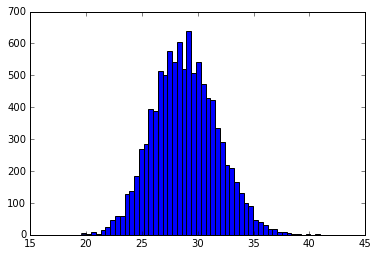

In [296]:
plt.hist(xbar, bins=50);

$29 \pm 3$

Bootstrapping is often used to determine the uncertainity of fit parameters

In [297]:
x = np.array([ 7.5,  8.1,  8.4,  8.8,  8.9,
               9.0,  9.1,  9.2,  9.3,  9.5,
               9.6,  9.9, 10.0, 10.05, 10.5,
              10.6, 10.6, 11.2, 11.8, 12.6 ])
x.size

20

In [298]:
y = np.array([22, 21, 19, 16, 18,
              15, 17, 17, 17, 19,
              14, 14, 15, 11, 12,
              12, 13, 10,  7,  9])
y.size

20

Slope:  -2.96942934494
Intersect: 43.7999710996


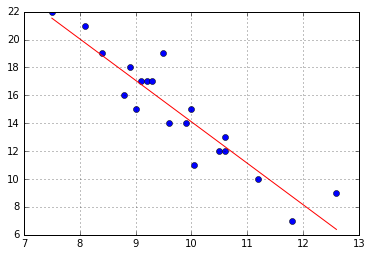

In [299]:
plt.plot(x,y,"o")
plt.grid(True)
slope, intersect = np.polyfit(x,y, 1)
plt.plot(x,slope*x+intersect,'-r')
print "Slope: ", slope
print "Intersect:", intersect

In [300]:
from scipy.stats import linregress
linreg = linregress(x,y)
print "Slope:", linreg.slope
print "Intersect:", linreg.intercept
print "Std Error:", linreg.stderr

Slope: -2.96942934494
Intersect: 43.7999710996
Std Error: 0.289810879821


But this is the error of the fit, what is the error of each parameter?

In [301]:
results = np.empty((10000,2))
for i in range(10000):
    ind = np.random.randint(20, size=20)
    slope, intercept = np.polyfit(x[ind],y[ind], 1)
    results[i][0], results[i][1] = slope, intercept

In [302]:
results[:,0].mean(), results[:,0].std()

(-3.0037107271184298, 0.32373109656383681)

In [303]:
results[:,1].mean(), results[:,1].std()

(44.107504456403923, 3.0854143593880985)

- Bootstrapping does not work for only few samples (N<20)
- Be careful about biases

## Cross validation

We know this from ML already

which model is a better fit?

$y = a + b x$

$y = a + b x + c x^2$

or higher polynomial?

- measure of error is rms (root of sum of squared errors)
- but more flexible models will always have lower RMS error

difference in mean squared error follows chi-square distribution

$$p(x, \nu) = \frac{1}{2^{\nu/2}\Gamma \left(\frac{\nu}{2}\right)} x ^{\frac{\nu}{2}-1} \exp \left({-\frac{1}{2}x}\right)$$

$\nu \approx \nu_2 - \nu_1$

$\nu_2 \approx (N - d_2)$

$\nu_1 \approx (N - d_1)$

models are nested, therefore one can estimate degrees of freedom easily

In [507]:
import numpy as np

np.random.seed(0)
true_fun = lambda X: 10 - 1. / (X + 0.1)

def make_data(N, err=1.0, rseed=1):
    # randomly sample the data
#    rng = np.random.RandomState(rseed)
    X = np.sort(np.random.rand(N))
    X = X[:, np.newaxis]
    #X = np.sort(rng.rand(N, 1))
    y = true_fun(X.ravel())
    if err > 0:
        y += err * 1.*np.random.randn(N)
    return X, y

N = 30
X, y = make_data(N)

In [508]:
def rms(y_real, y_predicted):
    return np.sqrt(np.mean( (y_real-y_predicted)**2) )

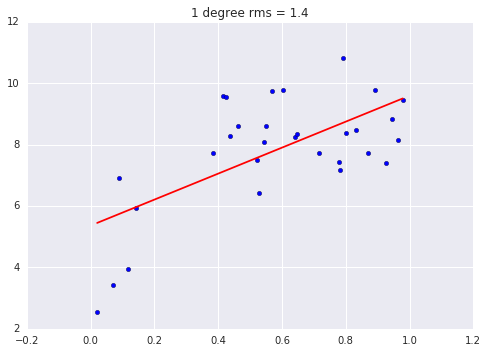

In [509]:
z1 = np.polyfit(X.ravel(), y, 1)
f1 = np.poly1d(z1)
y_new = f1(X.ravel())
plt.scatter(X.ravel(), y);
plt.plot(X.ravel(), y_new, color='red')
plt.title('1 degree rms = %.1f'%rms(y, y_new))

In [510]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rms1 = sqrt(mean_squared_error(y, y_new))
rms1

1.4167738123934264

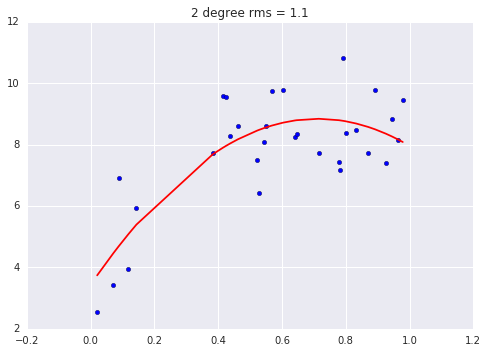

In [511]:
z2 = np.polyfit(X.ravel(), y, 2)
f2 = np.poly1d(z2)
y_new = f2(X.ravel())
plt.scatter(X.ravel(), y);
plt.plot(X.ravel(), y_new, color='red')
plt.title('2 degree rms = %.1f'%rms(y, y_new))

In [512]:
rms2 = sqrt(mean_squared_error(y, y_new))
rms2

1.134207969060934

Cross-validation idea:

1. Split data **randomly** in two sets
2. Fit both halves
3. Use the model and calculate the rms for the other half and vice versa
4. Compare rms and cross-validated rms

In [513]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                         LinearRegression(**kwargs))

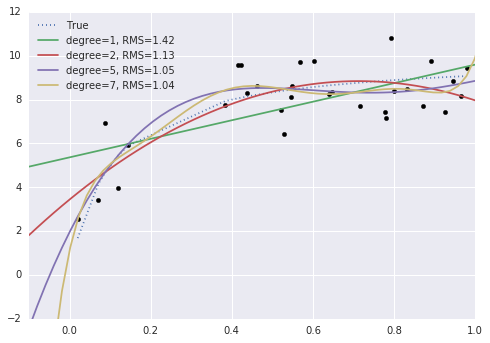

In [514]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn; seaborn.set()  # plot formatting

X_test = np.linspace(-0.1, 1.1, 2*N)[:, None]

plt.scatter(X.ravel(), y, color='black')
plt.plot(X.ravel(), true_fun(X.ravel()), label='True', linestyle=":")

axis = plt.axis()
for degree in [1, 2, 5, 7]:
    y_test = PolynomialRegression(degree).fit(X, y).predict(X_test)
    y_fool = PolynomialRegression(degree).fit(X, y).predict(X)
    rms_val = rms(y, y_fool)
#    scores = cross_validation.cross_val_score(PolynomialRegression(degree),
#        X, y, scoring="mean_squared_error", cv=cv)
    plt.plot(X_test.ravel(), y_test, label='degree={0}, RMS={1:.2f}'.format(degree, rms_val))
plt.xlim(-0.1, 1.0)
plt.ylim(-2, 12)
plt.legend(loc='best');

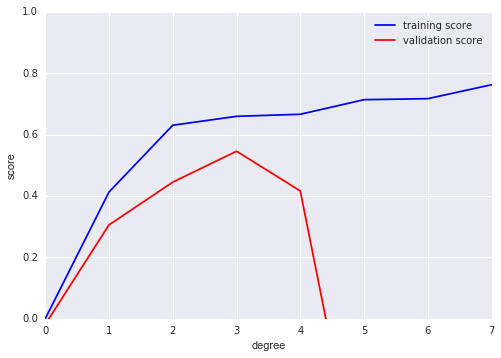

In [515]:
from sklearn.cross_validation import KFold
from sklearn import cross_validation

cv = KFold(N, n_folds=2, shuffle=True, random_state=1)


from sklearn.learning_curve import validation_curve
degree = np.arange(0, 8)
    
train_score, val_score = validation_curve(PolynomialRegression(),
                                          X, y,
                                          'polynomialfeatures__degree',
                                          degree,
                                          cv=cv)

plt.plot(degree, np.median(train_score, 1), color='blue', label='training score')
plt.plot(degree, np.median(val_score, 1), color='red', label='validation score')
plt.legend(loc='best')
plt.ylim(0, 1)
plt.xlabel('degree')
plt.ylabel('score');

Cross validation is often the only choice in machine learning, because the statistics of the models are typically not known.

## Monte Carlo Markov Chain Fitting

- MCMC is the most powerful tool in statistics
- Metropolis id in top 10 algorithms of 20th century (MEtropolis, Rosenbluth, Teller and Teller, 1953)

Gradient descent gives one value but does not say anything about variance/error. It just finds minimum of the best parameter theta. To see the variance we need a distribution. But distributions are expensive to sample all values enough times. Imagine 20 parameters, 20 dimensional space, sampling N^20

Bayesian statistics $P(\theta | data) = \frac{P(data | \theta) P(\theta)}{P(data)}$

Monte Carlo - (Los Alamos) replacing integrals with averaged sums (discrete - ready for computer simulations)

What is the chance to win any given game of solitaire?
 
$52! = 10^{67}$ configurations, number of atoms in Milky Way

Solution: Sampling!

Random walk through the probability distribution, favouring values with higher probabilites

1. Starting point
2. *Randomly* pick a nearby point and avaluate its probability.
3. If the probability is higher than the point we are, we move to the point. Otherise, we either stay or move to that point with some probability.

If we repeat this long enough, we will hit every point in the space with a frequency proportional to its probability

Trick: If it's difficult to sample from $\sim g(x)$, we can sample from $\sim q(x)$ and knowing $\frac{g(x)}{q(x)}$ we can apply the weights.

<img src="figures/mcmc-transitionmatrix.png" width="50%">

#### Markov Chain
$p(x_5 | x_4, x_3, x_2, x_1) = p(x_5 | x_4)$. No clusters (each point has a chance to be visited, irreducible), no cycles (aperiodic) graph.

$\nu_0 T^t \rightarrow \pi$ as $t\rightarrow \infty$

where $T$ is the stochastic transition matrix. $\nu$ is the initial vector of probabilities, $\pi$ is the invariant or statinary distribution of the chain. It is unique.

#### Python libraries

- PyMC
- emcee


1. initialise $x_0$
2. for $i$ in range($N$):
   - sample $u \sim U(0,1)$
   - sample $x^* \sim q(x^*| x_i )$ proposal point (dependent only on our current position)
   - if $u < A(x_i, x^*) = min(1,  (y(x^*) q((x_i | x^*) ) / (p(x_i) q(x^* | x_i )$

       $x_{i+1} = x^*$

     else

      $x_{i+1} = x_i$
     
 metropolis hastings $q((x_i | x^*) = q(x^* | x_i )$, probability depend only on distance, not direction

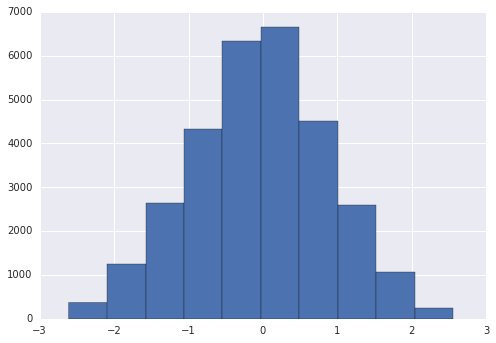

In [61]:
# let's try a trivial example, sampling from Gaussian of zero mean and std 1
# the proposal function will be Gaussian with sigma = 0.05
from scipy.stats import norm
import random

np.random.seed(1)

N = 30000
x = np.zeros(N)
x[0] = 0.5
sigma = 0.05
for i in range(N-1):
    x_c = sigma*norm.rvs() + x[i]
    #print x[i], x_c
    if np.random.rand() < norm.pdf(x_c)/norm.pdf(x[i]):
        x[i+1] = x_c
    else:
        x[i+1] = x[i]
plt.hist(x);

In [62]:
# Choose the "true" parameters.
m_true = -0.9594
b_true = 4.294
f_true = 0.534

# Generate some synthetic data from the model.
N = 50
x = np.sort(10*np.random.rand(N))
yerr = 0.1+0.5*np.random.rand(N)
y = m_true*x+b_true
y += np.abs(f_true*y) * np.random.randn(N)
y += yerr * np.random.randn(N)

In [63]:
# classical regression least square (analytic)

A = np.vstack((np.ones_like(x), x)).T
C = np.diag(yerr * yerr)
cov = np.linalg.inv(np.dot(A.T, np.linalg.solve(C, A)))
b_ls, m_ls = np.dot(cov, np.dot(A.T, np.linalg.solve(C, y)))

In [64]:
b_ls, m_ls

(4.4268276961313742, -0.90081036223915434)

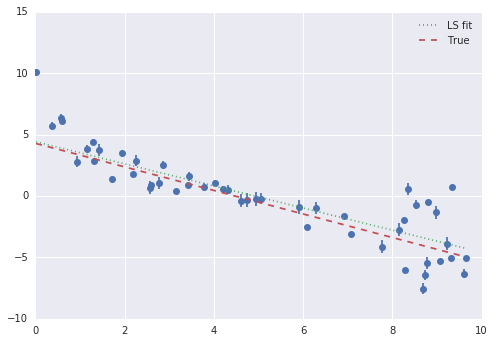

In [78]:
plt.errorbar(x,y,yerr=yerr, fmt='o')
plt.plot(x,m_ls*x + b_ls, ":", label="LS fit")
plt.plot(x,m_true*x + b_true, "--", label="True")
plt.legend(loc='best')

### Fitting a model with outliers (more parameters than values)

Great post from Jake Vanderplas  https://jakevdp.github.io/blog/2015/07/06/model-complexity-myth/

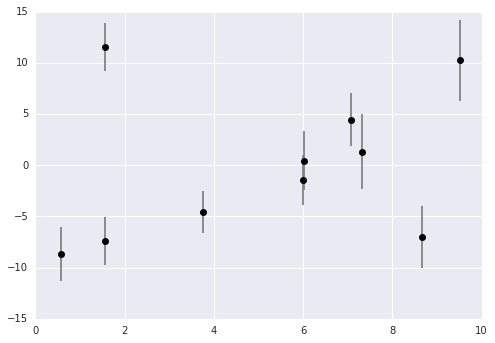

In [79]:
rng = np.random.RandomState(42)
theta = [-10, 2]
x = 10 * rng.rand(10)
dy = 2 + 2 * rng.rand(10)
y = theta[0] + theta[1] * x + dy * rng.randn(10)
y[4] += 15
y[7] -= 10
plt.errorbar(x, y, dy, fmt='ok', ecolor='gray');

If we try to fit a line using the standard $\chi^2$ minimization approach, we will find an obviously biased result, because $\chi^2$ is not robust to the presence of outliers.

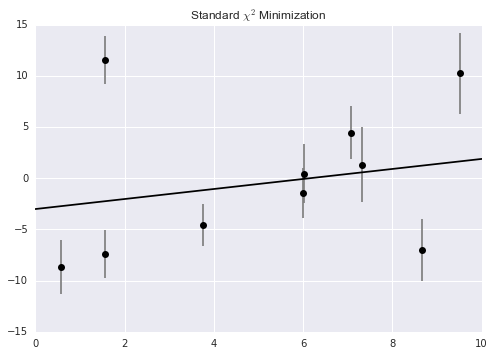

In [80]:
from scipy import optimize

def chi2(theta, x=x, y=y, dy=dy):
    y_model = theta[0] + theta[1] * x
    return np.sum(0.5 * ((y - y_model) / dy) ** 2)

theta1 = optimize.fmin(chi2, [0, 0], disp=False)

xfit = np.linspace(0, 10)
plt.errorbar(x, y, dy, fmt='ok', ecolor='gray')
plt.plot(xfit, theta1[0] + theta1[1] * xfit, '-k')
plt.title('Standard $\chi^2$ Minimization');

Let's propose a model which somehow accounts for the possibility that each of these points *may* be the result of a biased measurement.
One possible route is to add $N$ new model parameters: one associated with each point which indicates whether it is an outlier or not.
If it is an outlier, we use the standard model likelihood; if not, we use a likelihood with a much larger error.
The result for our straight-line fit will be a model with $N + 2$ parameters, where $N$ is the number of data points.
An overzealous application of lessons from simple linear models might lead you to believe this model can't be solved.
But, if carefully constructed, it can! Let's see how it can be done.

Our linear model is:

$$
y_M(x~|~\theta) = \theta_0 + \theta_1 x
$$

For a non-outlier (let's call it an "inlier") point at $x$, $y$, with error on $y$ given by $dy$, the likelihood is

$$
L_{in, i}(D~|~\theta) = \frac{1}{\sqrt{2\pi dy_i^2}} \exp\frac{-[y_i - y_M(x_i~|~\theta)]^2}{2 dy_i^2}
$$

For an "outlier" point, the likelihood is

$$
L_{out, i}(D~|~\theta) = \frac{1}{\sqrt{2\pi \sigma_y^2}} \exp\frac{-[y_i - y_M(x_i~|~\theta)]^2}{2 \sigma_y^2}
$$

where $\sigma_y$ is the standard deviation of the $y$ data: note that the only difference between the "inlier" and "outlier" likelihood is the width of the Gaussian distribution.

Now we'll specify $N$ additional binary model parameters $\{g_i\}_{i=1}^N$ which indicate whether point $i$ is an outlier $(g_i = 1)$ or an inlier $(g_i = 0)$.
With this, the overall Likelihood becomes:

$$
L(D~|~\theta, g) = \prod_i \left[(1 - g_i)~L_{in, i} + g_i~L_{out, i}\right]
$$

We will put a prior on these indicator variables $g$ which encourages sparsity of outliers; this can be accomplished with a simple L1 prior, which penalizes the sum of the $g$ terms:

$$
P(g) = \exp\left[-\sum_i g_i\right]
$$

where, recall, $g_i \in \{0, 1\}$.

make use of the excellent emcee package. Because emcee doesn't have categorical variables, we'll instead allow gi to range continuously between 0 and 1, so that any single point will be some mixture of "outlier" and "inlier".
We start by defining a function which computes the log-posterior given the data and model parameters, using some computational tricks for the sake of floating-point accuracy:

In [81]:
# theta will be an array of length 2 + N, where N is the number of points
# theta[0] is the intercept, theta[1] is the slope,
# and theta[2 + i] is the weight g_i

def log_prior(theta):
    g = theta[2:]
    #g_i needs to be between 0 and 1
    if (np.any(g < 0) or np.any(g > 1)):
        return -np.inf # recall log(0) = -inf
    else:
        return -g.sum()

def log_likelihood(theta, x, y, dy):
    sigma_y = np.std(y)
    y_model = theta[0] + theta[1] * x
    g = np.clip(theta[2:], 0, 1)  # g<0 or g>1 leads to NaNs in logarithm
    # log-likelihood for in-lier
    logL_in = -0.5 * (np.log(2 * np.pi * dy ** 2) + ((y - y_model) / dy)** 2)
    # log-likelihood for outlier
    logL_out = -0.5 * (np.log(2 * np.pi * sigma_y ** 2) + ((y - y_model) / sigma_y) ** 2)
    return np.sum(np.logaddexp(np.log(1 - g) + logL_in,
                               np.log(g) + logL_out))

def log_posterior(theta, x, y, dy):
    return log_prior(theta) + log_likelihood(theta, x, y, dy)

In [82]:
import emcee

ndim = 2 + len(x)  # number of parameters in the model
nwalkers = 50  # number of MCMC walkers
nburn = 10000  # "burn-in" period to let chains stabilize
nsteps = 15000  # number of MCMC steps to take

# set walkers near the maximum likelihood
# adding some random scatter
rng = np.random.RandomState(0)
starting_guesses = np.zeros((nwalkers, ndim))
starting_guesses[:, :2] = rng.normal(theta1, 1, (nwalkers, 2))
starting_guesses[:, 2:] = rng.normal(0.5, 0.1, (nwalkers, ndim - 2))

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[x, y, dy])
sampler.run_mcmc(starting_guesses, nsteps)

sample = sampler.chain  # shape = (nwalkers, nsteps, ndim)
sample = sampler.chain[:, nburn:, :].reshape(-1, ndim)

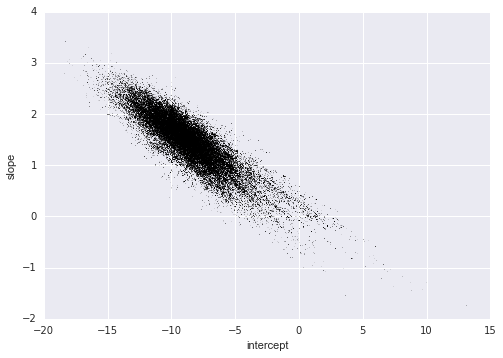

In [83]:
plt.plot(sample[:, 0], sample[:, 1], ',k', alpha=0.1)
plt.xlabel('intercept')
plt.ylabel('slope');

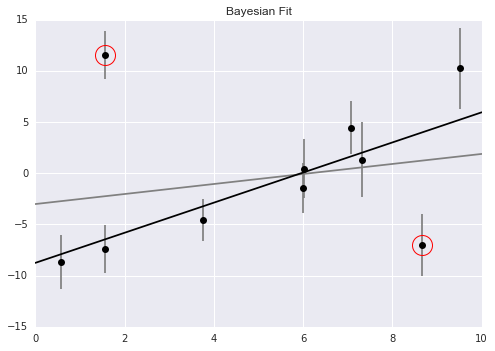

In [97]:
theta2 = np.mean(sample[:, :2], 0)
g = np.mean(sample[:, 2:], 0)
outliers = (g > 0.5)

plt.errorbar(x, y, dy, fmt='ok', ecolor='gray')
plt.plot(xfit, theta1[0] + theta1[1] * xfit, color='gray')
plt.plot(xfit, theta2[0] + theta2[1] * xfit, color='black')
plt.plot(x[outliers], y[outliers], 'ro', ms=20 , mew=1, mfc='none', mec='red')
plt.title('Bayesian Fit');

Notice that we have successfully fit an (N+2)-parameter model to N data points, and the best-fit parameters are actually meaningful in a deep way – the N extra parameters give us individual estimates of whether each of the N data points has misreported errors.

### The Mathematics of Underdetermined Models

To make more progress here, let's quickly dive into the mathematics behind these linear models.
Going back to the simple straight-line fit, we have our model

$$
y_M(x~|~\theta) = \theta_0 + \theta_1 x
$$

where we've replaced our slope $m$ and intercept $b$ by a more generalizable parameter vector $\theta = [\theta_0, \theta_1]$.
Given some set of data $\{x_n, y_n\}_{n=1}^N$ we'd like to find $\theta$ which gives the best fit.
For reasons I'll not discuss here, this is usually done by minimizing the sum of squared residuals from each data point, often called the $\chi^2$ of the model in reference to its expected theoretical distribution:

$$
\chi^2 = \sum_{n=1}^N [y_n - y_M(x_n~|~\theta)]^2
$$

We can make some progress by re-expressing this model in terms of matrices and vectors; we'll define the vector of $y$ values:

$$
y = [y_1, y_2, y_3, \cdots y_N]
$$

We'll also define the design matrix $X$; this contains all the information about the form of the model:

$$
X = \left[
\begin{array}{ll}
 1 & x_1 \\
 1 & x_2 \\
 \vdots &\vdots \\
 1 & x_N \\
\end{array}
\right]
$$

With this formalism, the vector of model values can be expressed as a matrix-vector product:

$$
y_M = X\theta
$$

and the $\chi^2$ can be expressed as a simple linear product as well:

$$
\chi^2 = (y - X\theta)^T(y - X\theta)
$$

We can make some progress by re-expressing this model in terms of matrices and vectors; we'll define the vector of $y$ values:

$$
y = [y_1, y_2, y_3, \cdots y_N]
$$

We'll also define the design matrix $X$; this contains all the information about the form of the model:

$$
X = \left[
\begin{array}{ll}
 1 & x_1 \\
 1 & x_2 \\
 \vdots &\vdots \\
 1 & x_N \\
\end{array}
\right]
$$

With this formalism, the vector of model values can be expressed as a matrix-vector product:

$$
y_M = X\theta
$$

and the $\chi^2$ can be expressed as a simple linear product as well:

$$
\chi^2 = (y - X\theta)^T(y - X\theta)
$$

We'd like to minimize the $\chi^2$ with respect to the parameter vector $\theta$, which we can do by the normal means of differentiating with respect to the vector $\theta$ and setting the result to zero (yes, you can take the derivative with respect to a vector!):

$$
\frac{d\chi^2}{d\theta} = -2X^T(y - X\theta) = 0
$$

Solving this for $\theta$ gives the *Maximum Likelihood Estimate (MLE)* for the parameters,

$$
\hat{\theta}_{MLE} = [X^T X]^{-1} X^T y
$$

Though this matrix formalism may seem a bit over-complicated, the nice part is that it straightforwardly generalizes to a host of more sophisticated linear models.
For example, the cubic model considered above requires only a larger design matrix $X$:

$$
X = \left[
\begin{array}{llll}
 1 & x_1 & x_1^2 & x_1^3\\
 1 & x_2 & x_2^2 & x_2^3\\
 \vdots & \vdots & \vdots & \vdots\\
 1 & x_N & x_N^2 & x_N^3\\
\end{array}
\right]
$$

The added model complexity is completely encapsulated in the design matrix, and the expression to compute $\hat{\theta}_{MLE}$ from $X$ is unchanged!

### Why Underdetermined Models Break

Taking a look at this Maximum Likelihood solution for $\theta$, we see that there is only one place that it might go wrong: the inversion of the matrix $X^T X$.
If this matrix is not invertible (i.e. if it is a singular matrix) then the maximum likelihood solution will not be well-defined.

The number of rows in $X$ corresponds to the number of data points, and the number of columns in $X$ corresponds to the number of parameters in the model.
It turns out that a matrix $C = X^TX$ will *always* be singular if $X$ has fewer rows than columns, and this is the source of the problem.
For underdetermined models, $X^TX$ is a singular matrix, and so the maximum likelihood fit is not well-defined.

Let's take a look at this in the case of fitting a line to the single point shown above, $(x=0.37, y=0.95)$.
For this value of $x$, here is the design matrix:

In [105]:
X = np.array([[1., 2.]])

In [106]:
C = np.dot(X.T, X)

In [107]:
C_inv = np.linalg.inv(C)

LinAlgError: Singular matrix

# Warning! Numpy inverse routine is broken and gives you wrong result even for underderterimned system! 

### Fixing an Underdetermined Model: Conditioning

One easy way to make a singular matrix invertible is to *condition* it: that is, you add to it some multiple of the identity matrix before performing the inversion (in many ways this is equivalent to "fixing" a divide-by-zero error by adding a small value to the denominator).
Mathematically, that looks like this:

$$
C = X^TX + \sigma I
$$

For example, by adding $\sigma = 10^{-3}$ to the diagonal of the normal matrix, we condition the matrix so that it can be inverted:

In [108]:
cond = 1E-3 * np.eye(2)
np.linalg.inv(C + cond)

array([[ 800.039992  , -399.920016  ],
       [-399.920016  ,  200.15996801]])

In [109]:
b, m = np.linalg.solve(C + cond,
                       np.dot(X.T, [0.95]))
print("Conditioned best-fit model:")
print("y = {0:.3f} x + {1:.3f}".format(m, b))

Conditioned best-fit model:
y = 0.380 x + 0.190


In a frequentist approach, this type of conditioning is known as **regularization**. Regularization is motivated by a desire to penalize large values of model parameters.
For example, in the underdetermined fit above (with $(x, y) = (0.37, 0.95)$), you could fit the data perfectly with a slope of one billion and an intercept near negative 370 million, but in most real-world applications this would be a silly fit.
To prevent this sort of canceling parameter divergence, in a frequentist setting you can "regularize" the model by adding a penalty term to the $\chi^2$; one popular choice is a penalty term proportional to the sum of squares of the model parameters themselves:

$$
\chi^2_{reg} = \chi^2 + \lambda~\theta^T\theta
$$

## Bayesian Conditioning: Priors

Regularization illuminates the meaning of matrix conditioning, but it still sometimes seems like a bit of black magic.
What does this penalization of model parameters within the $\chi^2$ actually mean?
Here, we can make progress in understanding the problem by examining regularization from a Bayesian perspective.

The Bayesian posterior probability on the model parameters $\theta$ is given by

$$
P(\theta~|~D, M) = \frac{P(D~|~\theta, M) P(\theta~|~M)}{P(D~|~M)}
$$

where the most important terms are the likelihood $P(D~|~\theta, M)$ and the prior $P(\theta~|~M)$.
From the expected correspondence with the frequentist result, we can write:

$$
P(D~|~\theta, M) P(\theta~|~M) \propto \exp[- \chi^2]
$$

Because the term on the right-hand-side has no $\theta$ dependence, we can immediately see that

$$
P(D~|~\theta, M) \propto \exp[-\chi^2]\\
P(\theta~|~M)  \propto 1
$$

That is, the simple frequentist likelihood is equivalent to the Bayesian posterior for the model with an implicit flat prior on $\theta$.

To understand the meaning of regularization, let's repeat this exercise with the regularized $\chi^2$:

$$
P(D~|~\theta, M) P(\theta~|~M) \propto \exp[- \chi^2 - \lambda~|\theta|^2]
$$

The regularization term in the $\chi^2$ becomes a second term in the product which depends only on $\theta$, thus we can immediately write

$$
P(D~|~\theta, M) \propto \exp[-\chi^2]\\
P(\theta~|~M)  \propto \exp[- \lambda~|\theta|^2]
$$

So we see that ridge regularization is equivalent to applying a Gaussian prior to your model parameters, centered at $\theta=0$ and with a width $\sigma_P = (2\lambda)^{-2}$.
This insight lifts the cover off the black box of regularization, and reveals that it is simply a roundabout way of adding a Bayesian prior within a frequentist paradigm.
The stronger the regularization, the narrower the implicit Gaussian prior is.

You can fit models with more parameters than data points, if you restrict your parameter space through the use of frequentist regularization or Bayesian priors.